# U-Net Implementation

For this implementation of a modified U-Net, I used the PyTorch libraries to structure the model. I also used some scikit-learn, NumPy, and matplotlib for some visualizations, pandas to load in the labels from the dataset, and PIL to load in the images itself.

In [1]:
# import statements
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image
from tqdm import tqdm

In [2]:
# defining magic function so that certain cells do not run again
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

### Reading in the dataset through Pandas

In a separate file, I cleaned through the original csv file that the BreakHis dataset gave to its users, so that the training data was separated from the testing data, and could be more easily utilized later on when defining our dataset variables. In addition, I extracted out the category and tumor type from the filename, and made them into their own columns, `category` and `tumor_type`.

In [3]:
# reading in dataset labels
training_set = pd.read_csv('training_set.csv')
testing_set = pd.read_csv('testing_set.csv')

In [4]:
training_set

,fold,mag,grp,filename,category,tumor_type
0,1,100,train,dataset/train/SOB_B_A-14-22549AB-100-001.png,benign,adenosis
1,1,100,train,dataset/train/SOB_B_A-14-22549AB-100-002.png,benign,adenosis
2,1,100,train,dataset/train/SOB_B_A-14-22549AB-100-003.png,benign,adenosis
3,1,100,train,dataset/train/SOB_B_A-14-22549AB-100-004.png,benign,adenosis
4,1,100,train,dataset/train/SOB_B_A-14-22549AB-100-005.png,benign,adenosis
...,...,...,...,...,...,...
5000,1,400,train,dataset/train/SOB_M_PC-15-190EF-400-011.png,malignant,papillary_carcinoma
5001,1,400,train,dataset/train/SOB_M_PC-15-190EF-400-012.png,malignant,papillary_carcinoma
5002,1,400,train,dataset/train/SOB_M_PC-15-190EF-400-013.png,malignant,papillary_carcinoma
5003,1,400,train,dataset/train/SOB_M_PC-15-190EF-400-014.png,malignant,papillary_carcinoma


In [5]:
testing_set

,fold,mag,grp,filename,category,tumor_type
0,1,100,test,dataset/test/SOB_B_A-14-22549G-100-001.png,benign,adenosis
1,1,100,test,dataset/test/SOB_B_A-14-22549G-100-002.png,benign,adenosis
2,1,100,test,dataset/test/SOB_B_A-14-22549G-100-003.png,benign,adenosis
3,1,100,test,dataset/test/SOB_B_A-14-22549G-100-004.png,benign,adenosis
4,1,100,test,dataset/test/SOB_B_A-14-22549G-100-005.png,benign,adenosis
...,...,...,...,...,...,...
2899,1,400,test,dataset/test/SOB_M_PC-14-15704-400-031.png,malignant,papillary_carcinoma
2900,1,400,test,dataset/test/SOB_M_PC-14-15704-400-032.png,malignant,papillary_carcinoma
2901,1,400,test,dataset/test/SOB_M_PC-14-15704-400-033.png,malignant,papillary_carcinoma
2902,1,400,test,dataset/test/SOB_M_PC-14-15704-400-034.png,malignant,papillary_carcinoma


In [6]:
# ensuring that the number of files in the system match the number in the DataFrames
len(os.listdir('dataset/train')) == training_set.shape[0], len(os.listdir('dataset/test')) == testing_set.shape[0]

(True, True)

### Implementing the model

The main use of U-Nets is image segmentation. In biomedical contexts, they are super simple and efficient in identifying organs, blood vessels, lesions, etc. They are also very good at identifying tumors, which is what this project is all about. However, we don't want an identification of where the tumor is. Instead, we want the model to recognize what kind of tumor is shown in the image.

Using PyTorch's NN (neural networks) library as a parent class, I modified the U-Net to better suit the purposes of this project. The initial parts of a U-Net are the same, with the convolutional blocks downsampling the image to extract features. Then instead of decoding the downsampled image, the modified U-Net implementation would go through the process of traditional neural network classification. This model doesn't need to decode the downsampled image, since we don't want an image from the model, but a classification instead.

In [7]:
# model class
class UNetEncoder(nn.Module):
    # inherit from torch.nn.Module
    def __init__(self, num_classes):
        super().__init__()

        # u-net encoder
        self.encoder = nn.ModuleList([
            self.conv_block(3, 64), 
            self.conv_block(64, 128),  
            self.conv_block(128, 256), 
            self.conv_block(256, 512), 
            self.conv_block(512, 1024) 
        ])

        # global pooling to replace the u-net decoder
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # classification part
        self.fc = nn.Linear(1024, num_classes)

    # implementation of a u-net convolutional block
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)

        x = self.global_pool(x) 
        x = torch.flatten(x, 1) 
        x = self.fc(x) 
        return x

### Dataset Preprocessing for the Model

Fortunately, the BreakHis dataset is super clean as-is. Unfortunately, the model cannot just take those images as-is. In order to accomplish this, I utilized the PyTorch Dataset and Dataloader. The PyTorch Dataset is able to hold our images and labels at the same time, while the Dataloader is an iterator that can feed the model images in batches, which speeds up the process if the program is ran on the cuda and parallelized.

In [8]:
class ImageDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        """
        Custom PyTorch Dataset to load images from file paths in a Pandas Series,
        and convert string labels into numerical labels.

        :param filepaths: Pandas Series containing file paths to images
        :param labels: Pandas Series containing string labels
        :param transform: Image transformations to apply
        """
        self.filepaths = filepaths.tolist()
        self.transform = transform

        # map string labels to numerical values
        self.label_mapping = {label: idx for idx, label in enumerate(sorted(labels.unique()))}
        self.labels = labels.map(self.label_mapping).tolist()

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx] 
        image = Image.open(img_path).convert("RGB")  
        label = self.labels[idx]  

        if self.transform:
            image = self.transform(image) 

        return image, label

Here, we are computing the mean and standard deviation of the pixels in the image in order to standardize the colors in the dataset, to help the model train better.

In [9]:
transformations = transforms.Compose([
    transforms.Resize((760, 400)),
    transforms.ToTensor()
])
training_dataset = ImageDataset(training_set['filename'], training_set['tumor_type'], transform=transformations)
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=False)

# Variables to hold sum and squared sum for mean/std calculation
mean = torch.zeros(3)
std = torch.zeros(3)
total_images = 0

# Loop through the dataset
for images, _ in tqdm(training_loader):
    batch_samples = images.size(0)
    images = images.view(batch_samples, 3, -1)  # Flatten the image to shape (batch_size, channels, width*height)
    
    mean += images.mean(dim=2).sum(dim=0)
    std += images.std(dim=2).sum(dim=0)
    total_images += batch_samples

# Final mean and std calculation
mean /= total_images
std /= total_images

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

100%|██████████| 157/157 [08:21<00:00,  3.19s/it]

Mean: tensor([0.7900, 0.6163, 0.7615])
Standard Deviation: tensor([0.1030, 0.1375, 0.0877])


Here, we are creating our training and testing sets using our modified PyTorch Dataset. I am transforming the data randomly to create some sort of variance in the dataset, so that the model doesn't just memorize certain patterns. The random transformations I am using are vertical and horizontal flips, which exposes the model to images in different orientations.

In [10]:
# transformations to create random variance in the dataset
transform_training = transforms.Compose([
    transforms.Resize((760, 400)),  # Ensure size is consistent
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally 50% of the time
    transforms.RandomVerticalFlip(p=0.5),    # Flip images vertically 50% of the time
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.7900, 0.6163, 0.7615], std=[0.1030, 0.1375, 0.0877])
])

training_dataset = ImageDataset(training_set['filename'], training_set['tumor_type'], transform=transform_training)

In [11]:
transform_testing = transforms.Compose([
    transforms.Resize((760, 400)),  # Ensure size is consistent
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally 50% of the time
    transforms.RandomVerticalFlip(p=0.5),    # Flip images vertically 50% of the time
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.7900, 0.6163, 0.7615], std=[0.1030, 0.1375, 0.0877])
])

testing_dataset = ImageDataset(testing_set['filename'], testing_set['tumor_type'], transform=transform_testing)

In [12]:
# label mapping
print(f'Label Mapping: {testing_dataset.label_mapping}')

Label Mapping: {'adenosis': 0, 'ductal_carcinoma': 1, 'fibroadenoma': 2, 'lobular_carcinoma': 3, 'mucinous_carcinoma': 4, 'papillary_carcinoma': 5, 'phyllodes_tumor': 6, 'tubular_adenoma': 7}


### Actually Training the Model!

Here, I am defining any constants before entering the training loop.
<ul>
    <li><code>num_epochs</code>: the number of times should the training loop should iterate (this number is not that significant for later reasons)</li>
    <li><code>device</code>: the device (cuda/cpu) the training loops should be done on (this will be the cuda almost everytime)</li>
    <li><code>patience</code>: the reason why <code>num_epochs</code> doesn't really matter, specifies how many iterations the models will keep going for after not improving (this is to prevent significant overfitting)</li>
    <li><code>model</code>: the model itself</li>
    <li><code>criterion</code>: the loss function used to measure the performance of the model (in this training loop, we used cross-entropy)</li>
    <li><code>optimizer</code>: an algorithm used for gradient descent (in other words, tells the model how it should improve in future training iterations)</li>
</ul>

In [13]:
# define constants
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patience = 0
model = UNetEncoder(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Here, I am splitting 10% of the dataset into a validation set. This is for the algorithm to measure how it's doing on unseen data. The validation data is also what the model will use to see if it is improving or not (and thus, run out of patience and stop training).

In [14]:
# split the dataset
val_size = int(0.1 * training_set.shape[0])
train_size = training_set.shape[0] - val_size
training_dataset, validation_dataset = random_split(training_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(45))

# initialize training and validation loaders
train_loader = DataLoader(training_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

Here is the code that actually trains the model! 

Side note: the magic function `%%skip` is for me to run the Jupyter notebook cells without training the model again.

In [15]:
%%skip

# training model
for epoch in range(num_epochs):
    # train model
    model.train()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # validation 
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in validation_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()

            _, predicted = torch.max(val_outputs, 1)
            val_correct += (predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    avg_val_loss = val_loss / len(validation_loader)
    val_accuracy = 100 * val_correct / val_total
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # considering the model's patience...
    if avg_val_loss < best_val_loss - 0.02:
        patience = 0
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"models/best_model.pth")
        print(f'model saved with validation loss of {best_val_loss}')
    else:
        patience += 1
        if patience == 3:
            print(f'reached patience of 3 on epoch {epoch}')
            break

### Evaluating the Model

Now that we've trained the model, let's see how we've done! Let's load in the best iteration of our model, and test it on the BreakHis testing set that we set aside earlier.

In [16]:
# loading in the model after training
model = UNetEncoder(num_classes=8)
model.load_state_dict(torch.load(f'models/best_model.pth'))
model.to(device)
testing_loader = DataLoader(testing_dataset)

In [17]:
# evaluate model on testing set
model.eval() 
test_actual = []
test_predicted = []

with torch.no_grad():
    for test_images, test_labels in tqdm(testing_loader):
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_outputs = model(test_images)

        _, predicted = torch.max(test_outputs, 1)

        test_actual.append(test_labels.cpu())
        test_predicted.append(predicted.cpu())

100%|██████████| 2904/2904 [04:41<00:00, 10.30it/s]


In [18]:
# testing accuracy for trained model...
test_actual = torch.cat(test_actual).numpy()
test_predicted = torch.cat(test_predicted).numpy()
test_results = test_actual == test_predicted
test_accuracy = test_results.mean() * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 41.67%


As we can see, the results aren't great... only 41.8% :( 

Let's visualize this!

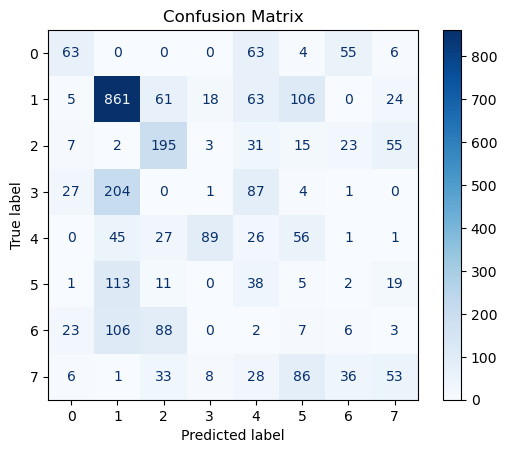

In [19]:
# create multiclass confusion matrix
cm = confusion_matrix(test_actual, test_predicted)

fig = ConfusionMatrixDisplay(confusion_matrix=cm) 
fig.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [20]:
# labels for reference
testing_dataset.label_mapping

{'adenosis': 0,
 'ductal_carcinoma': 1,
 'fibroadenoma': 2,
 'lobular_carcinoma': 3,
 'mucinous_carcinoma': 4,
 'papillary_carcinoma': 5,
 'phyllodes_tumor': 6,
 'tubular_adenoma': 7}

Each of the labels map to a type of tumor. The mapping can The testing set was super heavy on tumors with ductal carcinoma, and our model also heavily predicted ductal carcinoma, even when the tumor was not. Let's see if the model was correct on a binary scale (classifying whether a tumor was a benign type or malignant type).

In [21]:
# translating the model's predictions to a binary scale (benign/malignant)
binary_mapping = {0: 'benign', 1: 'malignant', 2: 'benign', 3: 'malignant', 4: 'malignant', 5: 'malignant', 6: 'benign', 7: 'benign'}
binary_actual = np.array([binary_mapping[num] for num in test_actual])
binary_predicted = np.array([binary_mapping[num] for num in test_predicted])

In [22]:
# binary accuracy... better!
binary_results = binary_actual == binary_predicted
binary_accuracy = binary_results.mean() * 100
print(f'Binary Accuracy: {binary_accuracy:.2f}%')

Binary Accuracy: 81.54%


Significantly better!

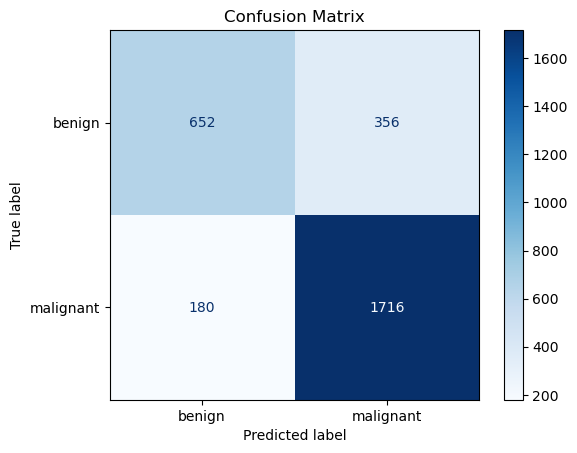

In [23]:
# create binary confusion matrix
cm = confusion_matrix(binary_actual, binary_predicted)

true_labels = ['benign', 'malignant']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=true_labels) 

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

When the model predicts that tumor is malignant, how often is it actually right? We can measure this through precision, which is defined as the number of true positive results divided by the total number of positive predictions that the model made. 

$$\text{precision} = \frac{\text{true positives}}{\text{true positives + false positives}} = \frac{1711}{1711 + 355} \approx 0.828$$

This means that the model is correct when predicting malignant tumors about 82.8% of the time.

What about correctly identifying malignant tumors? Of all of the images that were malignant, how many did the model actually catch? There's an alternative metric for this, called recall, which is defined as the number of true positive results divided by the number of images that were actually positive.

$$\text{precision} = \frac{\text{true positives}}{\text{true positives + false negatives}} = \frac{1711}{1711 + 185} \approx 0.902$$

Given a malignant tumor, the model will make the correct prediction around 90.2% of the time.

In the context of breast tumors, we want to prioritize recall a little bit more than precision. Recall represents the scenario that a patient has a malignant tumor and our model correctly predicts it. Precision represents the scenario that a patient may or may not have a malignant, and our model predicts that, yes, they do have a malignant tumor. Recall is a little more important in the medical field than precision because doctors would rather incorrectly diagnose a patient and run more tests, than to administer a test and completely miss a life-endangering tumor.